The following code produce the climate change factors used by ecosim

In [11]:
# Get the current directory
import os
current_dir = os.getcwd()

# Print the current directory
print("Current directory:", current_dir)

#read time series of annual mean
#specify the output file
# the CO2 time series covers from 1749 to 2022
# the CH4 time series covers from 1750 to 2022
ncf_atmgas='../input_data/fatm_hist_GHGs_1750-2022.nc'
yearb=1750
yeare=2022
#specify the source file for time series data of atmospheric co2 and ch4
fco2_ch4='../input_data/atms_ghg_1750-now.csv'

co2s=[]
ch4s=[]
n2os=[]
unit_co2='ppm'
unit_ch4='ppb'
unit_n2o='ppb'
with open(fco2_ch4,"r") as infile:
    #read and skip the first line
    dat_src=infile.readline()
    line=infile.readline().strip()

    while line:
        #split string by spaces, including spaces, tabs, and newline characters
        sarr=line.split(',')
        if len(sarr) ==3:
            year=float(sarr[0])
            dat1=float(sarr[1])
            if 'CO2' in sarr[2]:
                co2s.append(year)
                co2s.append(dat1)
                
            elif 'CH4' in sarr[2]:
                ch4s.append(year)
                ch4s.append(dat1)
            elif 'N2O' in sarr[2]:
                n2os.append(year)
                n2os.append(dat1)
        line=infile.readline().strip()

len_co2s=int(len(co2s)/2)
len_ch4s=int(len(ch4s)/2)
len_n2os=int(len(n2os)/2)
print('# of co2 data: %d,yearb=%d,yeare=%d'%(len_co2s,co2s[0],co2s[-2]))    
print('# of ch4 data: %d,yearb=%d,yeare=%d'%(len_ch4s,ch4s[0],ch4s[-2]))   
print('# of n2o data: %d,yearb=%d,yeare=%d'%(len_n2os,n2os[0],n2os[-2]))   

import numpy as np

co2_arr=np.array(co2s)
ch4_arr=np.array(ch4s)
n2o_arr=np.array(n2os)

co2s=co2_arr.reshape(len_co2s,2)
ch4s=ch4_arr.reshape(len_ch4s,2)
n2os=n2o_arr.reshape(len_n2os,2)

Current directory: /Users/jinyuntang/work/github/ecosim3/EcoSIM/python_tools
# of co2 data: 106,yearb=1750,yeare=2022
# of ch4 data: 91,yearb=1750,yeare=2022
# of n2o data: 91,yearb=1750,yeare=2022


In [12]:
#read time series of monthly data
def read_mongas(fts):
    with open(fts,"r") as infile:
        #read and skip the first line
        dat_src=infile.readline()
        line1=infile.readline().strip()    
        found=False
        start=False
        ts_mon=[]
        ts_year=[]
        ts_loc=[]
        yearb=0
        yeare=0
        while line1:
            line=line1.strip()
            if line:
                if found:
                    sarr=line.split(',')
                    mon=int(sarr[1])
                    if start:                   
                        if mon==12:
                            yeare=int(sarr[0])
                            ts_loc.append(float(sarr[3]))                           
                            ave_yr=np.mean(np.array(ts_loc))
                            ts_year.append(ave_yr)
                            ts_mon.extend(ts_loc-ave_yr)
                            ts_loc=[]
                        else:
                            ts_loc.append(float(sarr[3]))
                    elif mon==1:
                        start=True
                        yearb=int(sarr[0])
                        ts_loc=[]
                        ts_loc.append(float(sarr[3]))                    
                elif "year,month," in line:
                    found=True                
            line1=infile.readline()
        return ts_year,ts_mon,yearb,yeare        
fco2='../input_data/co2_mm_gl.csv'
fch4='../input_data/ch4_mm_gl.csv'
fn2o='../input_data/n2o_mm_gl.csv'

ts_co2_yr,ts_co2_mon,yearb_co2,yeare_co2=read_mongas(fco2)        
ts_ch4_yr,ts_ch4_mon,yearb_ch4,yeare_ch4=read_mongas(fch4)
ts_n2o_yr,ts_n2o_mon,yearb_n2o,yeare_n2o=read_mongas(fn2o)

print('co2=%d,%d,%d,%d'%(len(ts_co2_yr),len(ts_co2_mon),yearb_co2,yeare_co2))
print('ch4=%d,%d,%d,%d'%(len(ts_ch4_yr),len(ts_ch4_mon),yearb_ch4,yeare_ch4))
print('n2o=%d,%d,%d,%d'%(len(ts_n2o_yr),len(ts_n2o_mon),yearb_n2o,yeare_n2o))




co2=44,528,1979,2022
ch4=39,468,1984,2022
n2o=22,264,2001,2022


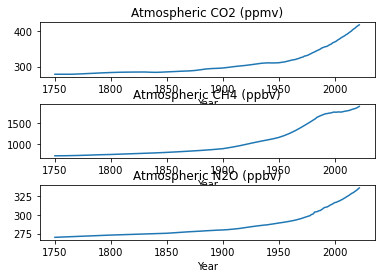

In [13]:
#plot time series data
import matplotlib.pyplot as plt
plt.subplot(3,1,1)
plt.plot(co2s[:,0], co2s[:,1])
plt.xlabel('Year')
plt.title('Atmospheric CO2 (ppmv)')
plt.subplot(3,1,2)
plt.plot(ch4s[:,0],ch4s[:,1])
plt.xlabel('Year')
plt.title('Atmospheric CH4 (ppbv)')
plt.subplot(3,1,3)
plt.plot(n2os[:,0],n2os[:,1])
plt.xlabel('Year')
plt.title('Atmospheric N2O (ppbv)')
plt.subplots_adjust(hspace=0.5)


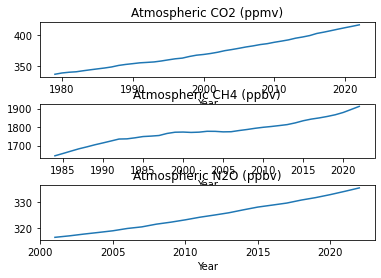

In [14]:
import matplotlib.pyplot as plt
plt.subplot(3,1,1)
plt.plot(range(yearb_co2,yeare_co2+1),ts_co2_yr)
plt.xlabel('Year')
plt.title('Atmospheric CO2 (ppmv)')
plt.subplot(3,1,2)
plt.plot(range(yearb_ch4,yeare_ch4+1),ts_ch4_yr)
plt.xlabel('Year')
plt.title('Atmospheric CH4 (ppbv)')
plt.subplot(3,1,3)
plt.plot(range(yearb_n2o,yeare_n2o+1),ts_n2o_yr)
plt.xlabel('Year')
plt.title('Atmospheric N2O (ppbv)')
plt.subplots_adjust(hspace=0.5)

write as netcdf file

In [39]:
from netCDF4 import Dataset
from datetime import datetime
from array import array
import warnings
from scipy.interpolate import interp1d

#first interpolate data to 1750 to 2022
#create function
f_ch4=interp1d(ch4s[:,0],ch4s[:,1])
f_co2=interp1d(co2s[:,0],co2s[:,1])
f_n2o=interp1d(n2os[:,0],n2os[:,1])
#interpolate
year_intp=np.array(range(1750, 2023))
ch4_intp=np.tile(f_ch4(year_intp),(12, 1))
co2_intp=np.tile(f_co2(year_intp),(12, 1))
n2o_intp=np.tile(f_n2o(year_intp),(12, 1))

def add_samp(ts_intp,ts_mon,yearb,yeare):
    """
    add seasonal variation
    """
    
    ts_smon=np.zeros(ts_intp.size)
    for yr in range(1750,2023):
        k=yr-1750
        
        if yr <= yearb:
            ts_smon[k*12:(k+1)*12]=ts_intp[:,k]+ts_mon[0:12]
            k1=12
            k2=24
        else:
            ts_smon[k*12:(k+1)*12]=ts_intp[:,k]+ts_mon[k1:k2]
            k1=k2
            k2=k2+12
        
    return ts_smon    

ts_co2_smon=add_samp(co2_intp,ts_co2_mon,yearb_co2,yeare_co2)
ts_ch4_smon=add_samp(ch4_intp,ts_ch4_mon,yearb_ch4,yeare_ch4)
ts_n2o_smon=add_samp(n2o_intp,ts_n2o_mon,yearb_n2o,yeare_n2o)
            
years=(np.arange(ts_co2_smon.size)+1)/12.+1750

(3276,)
(3276,)
(3276,)
[277.70916667 278.43916667 279.02916667 279.46916667 279.40916667
 278.52916667 276.70916667 275.51916667 276.16916667 277.50916667
 278.50916667 278.99916667 277.70916667 278.43916667 279.02916667
 279.46916667 279.40916667 278.52916667 276.70916667 275.51916667
 276.16916667 277.50916667 278.50916667 278.99916667]
2023.0
5


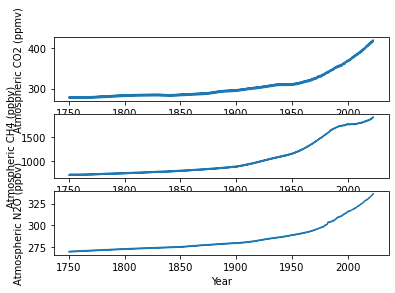

In [40]:
#re-check the interpolated data 
plt.subplot(3,1,1)
plt.plot(years,ts_co2_smon)
plt.xlabel('Year')
plt.ylabel('Atmospheric CO2 (ppmv)')
plt.subplot(3,1,2)
plt.plot(years,ts_ch4_smon)
plt.xlabel('Year')
plt.ylabel('Atmospheric CH4 (ppbv)')
plt.subplot(3,1,3)
plt.plot(years,ts_n2o_smon)
plt.xlabel('Year')
plt.ylabel('Atmospheric N2O (ppbv)')
print(ts_co2_smon.shape)
print(ts_ch4_smon.shape)
print(ts_n2o_smon.shape)
print(ts_co2_smon[0:24])
print(((years[-1])))
print(int(12*(5./12)))

In [41]:
#write netcdf file

current_dateTime = datetime.now()
print('File to write: %s'%ncf_atmgas)
nc_fid = Dataset(ncf_atmgas, 'w')

nc_fid.description='historical atmospheric CO2 and CH4 time series created on %4d/%02d/%02d/%02d:%02d:%02d'% \
      (current_dateTime.year,current_dateTime.month,current_dateTime.day, \
      current_dateTime.hour,current_dateTime.minute,current_dateTime.second)+'; data source:'+dat_src

nc_fid.createDimension('time', None)
w_nc_var=nc_fid.createVariable('CH4','f4', ('time'))
w_nc_var.long_name='Atmospheric CH4 concentrations'
w_nc_var.units='ppbv'

w_nc_var=nc_fid.createVariable('CO2', 'f4', ('time'))
w_nc_var.long_name='Atmospheric CO2 concentration'
w_nc_var.units='ppmv'

w_nc_var=nc_fid.createVariable('N2O', 'f4', ('time'))
w_nc_var.long_name='Atmospheric N2O concentration'
w_nc_var.units='ppbv'

w_nc_var=nc_fid.createVariable('year', 'f4', ('time'))
w_nc_var.long_name='Year AD'

for k in range(len(years)):
    nc_fid.variables['year'][k]=years[k]
    nc_fid.variables['CO2'][k]=ts_co2_smon[k]
    nc_fid.variables['CH4'][k]=ts_ch4_smon[k]
    nc_fid.variables['N2O'][k]=ts_n2o_smon[k]
    

nc_fid.close()

File to write: ../input_data/fatm_hist_GHGs_1750-2022.nc


In [42]:
print(1.e6/3600.)

277.77777777777777
